In [1]:
from einops import EinopsError
import keyword
import warnings

_ellipsis = '…'  # NB, this is a single unicode symbol. String is used as it is not a list, but can be iterated


class AnonymousAxis(object):
    """Important thing: all instances of this class are not equal to each other """
    def __init__(self, value: str):
        self.value = int(value)
        if self.value <= 1:
            if self.value == 1:
                raise EinopsError('No need to create anonymous axis of length 1. Report this as an issue')
            else:
                raise EinopsError('Anonymous axis should have positive length, not {}'.format(self.value))

    def __repr__(self):
        return "{}-axis".format(str(self.value))


In [2]:
class ParsedExpression:
    """
    non-mutable structure that contains information about one side of expression (e.g. 'b c (h w)')
    and keeps some information important for downstream
    """

    # non-mutable structure than contains
    def __init__(self, expression):
        self.has_ellipsis = False
        self.has_ellipsis_parenthesized = None
        self.identifiers = set()
        # that's axes like 2, 3 or 5. Axes with size 1 are exceptional and replaced with empty composition
        self.has_non_unitary_anonymous_axes = False
        self.composition = []
        if '.' in expression:
            if '...' not in expression:
                raise EinopsError('Expression may contain dots only inside ellipsis (...)')
            if str.count(expression, '...') != 1 or str.count(expression, '.') != 3:
                raise EinopsError(
                    'Expression may contain dots only inside ellipsis (...); only one ellipsis for tensor ')
            expression = expression.replace('...', _ellipsis)
            self.has_ellipsis = True

        bracket_group = None

        def add_axis_name(x):
            print('x', x)
            if x is not None:
                if x in self.identifiers:
                    raise EinopsError('Indexing expression contains duplicate dimension "{}"'.format(x))
                if x == _ellipsis:
                    self.identifiers.add(_ellipsis)
                    if bracket_group is None:
                        self.composition.append(_ellipsis)
                        self.has_ellipsis_parenthesized = False
                    else:
                        bracket_group.append(_ellipsis)
                        self.has_ellipsis_parenthesized = True
                else:
                    is_number = str.isdecimal(x)
                    if is_number and int(x) == 1:
                        # handling the case of anonymous axis of length 1
                        if bracket_group is None:
                            self.composition.append([])
                        else:
                            pass  # no need to think about 1s inside parenthesis
                        return
                    is_axis_name, reason = self.check_axis_name(x, return_reason=True)
                    if not (is_number or is_axis_name):
                        raise EinopsError('Invalid axis identifier: {}\n{}'.format(x, reason))
                    if is_number:
                        x = AnonymousAxis(x)
                    self.identifiers.add(x)
                    if is_number:
                        self.has_non_unitary_anonymous_axes = True
                    if bracket_group is None:
                        self.composition.append([x])
                    else:
                        bracket_group.append(x)

        current_identifier = None
        for char in expression:
            if char in '() ':
                add_axis_name(current_identifier)
                current_identifier = None
                if char == '(':
                    if bracket_group is not None:
                        raise EinopsError("Axis composition is one-level (brackets inside brackets not allowed)")
                    bracket_group = []
                elif char == ')':
                    if bracket_group is None:
                        raise EinopsError('Brackets are not balanced')
                    self.composition.append(bracket_group)
                    bracket_group = None
            elif str.isalnum(char) or char in ['_', _ellipsis]:
                if current_identifier is None:
                    current_identifier = char
                else:
                    current_identifier += char
            else:
                raise EinopsError("Unknown character '{}'".format(char))

        if bracket_group is not None:
            raise EinopsError('Imbalanced parentheses in expression: "{}"'.format(expression))
        add_axis_name(current_identifier)

    @staticmethod
    def check_axis_name(name: str, return_reason=False):
        """
        Valid axes names are python identifiers except keywords,
        and additionally should not start or end with underscore
        """
        if not str.isidentifier(name):
            result = False, 'not a valid python identifier'
        elif name[0] == '_' or name[-1] == '_':
            result = False, 'axis name should should not start or end with underscore'
        else:
            if keyword.iskeyword(name):
                warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)
            if name in ['axis']:
                warnings.warn("It is discouraged to use 'axis' as an axis name "
                              "and will raise an error in future", FutureWarning)
            result = True, None
        if return_reason:
            return result
        else:
            return result[0]

In [5]:
x = ParsedExpression("A Z")

x A
x Z


In [6]:
x.composition

[['A'], ['Z']]

In [7]:
def _product(sequence):
    # minimalistic product that works both with numbers and symbols. Supports empty lists
    result = 1
    for element in sequence:
        result *= element
    return result

In [10]:
def _optimize_transformation(init_shapes, reduced_axes, axes_reordering, final_shapes):
    # TODO this method is very slow
    assert len(axes_reordering) + len(reduced_axes) == len(init_shapes)
    # joining consecutive axes that will be reduced
    # possibly we can skip this if all backends can optimize this (not sure)
    reduced_axes = tuple(sorted(reduced_axes))
    for i in range(len(reduced_axes) - 1)[::-1]:
        if reduced_axes[i] + 1 == reduced_axes[i + 1]:
            removed_axis = reduced_axes[i + 1]
            removed_length = init_shapes[removed_axis]
            init_shapes = init_shapes[:removed_axis] + init_shapes[removed_axis + 1:]
            init_shapes[removed_axis - 1] *= removed_length
            reduced_axes = reduced_axes[:i + 1] + tuple(axis - 1 for axis in reduced_axes[i + 2:])

    # removing axes that are moved together during reshape
    def build_mapping():
        init_to_final = {}
        for axis in range(len(init_shapes)):
            if axis in reduced_axes:
                init_to_final[axis] = None
            else:
                after_reduction = sum(x is not None for x in init_to_final.values())
                init_to_final[axis] = list(axes_reordering).index(after_reduction)
        return init_to_final

    init_axis_to_final_axis = build_mapping()

    for init_axis in range(len(init_shapes) - 1)[::-1]:
        if init_axis_to_final_axis[init_axis] is None:
            continue
        if init_axis_to_final_axis[init_axis + 1] is None:
            continue
        if init_axis_to_final_axis[init_axis] + 1 == init_axis_to_final_axis[init_axis + 1]:
            removed_axis = init_axis + 1
            removed_length = init_shapes[removed_axis]
            removed_axis_after_reduction = sum(x not in reduced_axes for x in range(removed_axis))

            reduced_axes = tuple(axis if axis < removed_axis else axis - 1 for axis in reduced_axes)
            init_shapes = init_shapes[:removed_axis] + init_shapes[removed_axis + 1:]
            init_shapes[removed_axis - 1] *= removed_length
            old_reordering = axes_reordering
            axes_reordering = []
            for axis in old_reordering:
                if axis == removed_axis_after_reduction:
                    pass
                elif axis < removed_axis_after_reduction:
                    axes_reordering.append(axis)
                else:
                    axes_reordering.append(axis - 1)
            init_axis_to_final_axis = build_mapping()

    return init_shapes, reduced_axes, axes_reordering, final_shapes

In [12]:
def reduce(reduction: str, **axes_lengths: int):
    print(axes_lengths)
    

In [18]:
import einops

In [21]:
pattern = "x y -> (x y)"
axes_lengths = tuple(sorted(dict(x=5, y=10)))

In [23]:
from typing import Tuple, List, Set, Dict
CompositeAxis = List[str]

In [25]:
def parse_expression(expression: str) -> Tuple[Set[str], List[CompositeAxis]]:
    """
    Parses an indexing expression (for a single tensor).
    Checks uniqueness of names, checks usage of '...' (allowed only once)
    Returns set of all used identifiers and a list of axis groups.
    """
    identifiers = set()
    composite_axes = []
    if '.' in expression:
        if '...' not in expression:
            raise EinopsError('Expression may contain dots only inside ellipsis (...)')
        if str.count(expression, '...') != 1 or str.count(expression, '.') != 3:
            raise EinopsError('Expression may contain dots only inside ellipsis (...); only one ellipsis for tensor ')
        expression = expression.replace('...', _ellipsis)

    bracket_group = None

    def add_axis_name(x):
        if x is not None:
            if x in identifiers:
                raise ValueError('Indexing expression contains duplicate dimension "{}"'.format(x))
            identifiers.add(x)
            if bracket_group is None:
                composite_axes.append([x])
            else:
                bracket_group.append(x)

    current_identifier = None
    for char in expression:
        if char in '() ' + _ellipsis:
            add_axis_name(current_identifier)
            current_identifier = None
            if char == _ellipsis:
                if bracket_group is not None:
                    raise EinopsError("Ellipsis can't be used inside the composite axis (inside brackets)")
                composite_axes.append(_ellipsis)
                identifiers.add(_ellipsis)
            elif char == '(':
                if bracket_group is not None:
                    raise EinopsError("Axis composition is one-level (brackets inside brackets not allowed)")
                bracket_group = []
            elif char == ')':
                if bracket_group is None:
                    raise EinopsError('Brackets are not balanced')
                composite_axes.append(bracket_group)
                bracket_group = None
        elif '0' <= char <= '9':
            if current_identifier is None:
                raise EinopsError("Axis name can't start with a digit")
            current_identifier += char
        elif 'a' <= char <= 'z' or 'A' <= char <= 'Z':
            if current_identifier is None:
                current_identifier = char
            else:
                current_identifier += char
        else:
#             if 'A' <= char <= 'Z':
#                 raise EinopsError("Only lower-case latin letters allowed in names, not '{}'".format(char))
            raise EinopsError("Unknown character '{}'".format(char))

    if bracket_group is not None:
        raise EinopsError('Imbalanced parentheses in expression: "{}"'.format(expression))
    add_axis_name(current_identifier)
    return identifiers, composite_axes

In [113]:
a, b = parse_expression("Batch W H")

In [100]:
import torch
import numpy as np

In [102]:
from PIL import Image

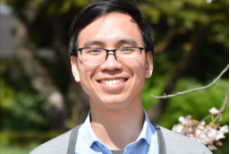

In [497]:
img = Image.open("ava.png")
img

In [507]:
img = np.array(img)
tensor = einops.rearrange(img, "h w c ->() h w c")

In [508]:
tensor.shape

(1, 154, 231, 4)

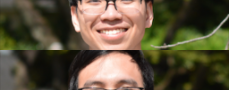

In [509]:
Image.fromarray(tensor[:, list(range(50, 100)) + list(range(10, 50)), :, :][0])

In [510]:
start = time.time()
for i in range(10000):
    # tensor.take(indices=range(0, 150), axis=2)
    tensor[:, :, 0:150, :]
    # torch_tensor[:, 0:150, :, :]
    # torch_tensor[:, list(range(0, 150)), :, :]
    
end = time.time()

print(f"Total time {end-start:.5f}s")

Total time 0.00807s


In [511]:
pattern = "B H W [(r g b a) -> (b g r)]"
axes_lengths = dict(B=1, H=154, W=231)

In [583]:
def concat(tensor_list, pattern, **axes_lengths: int):
    """This perform the concatenation of tensors along 1 axis. 
    Note that:
    1. Except the concatenated axis, the lengths of the other axes must be the same.
    2. It is not necessary for all tensors to have the same length, they can be different.
    3. We DONT need to specify all the lengths of dimensions.

    Example:
    >>> x = torch.randn(2, 10, 512)
    >>> y = torch.randn(2, 10, 128)
    >>> z = torch.randn(2, 10, 256)
    >>> h = concat([x, y, z], "batch seq [dx dy dz -> (dx dy dz)]", batch=2, seq=10, dx=512, dy=128, dz=256)
    """
    
    left, rght, dim_left, dim_rght = _split_pattern(pattern)

    identifiers_left, composite_axes_left = parse_expression(left)
    identifiers_rght, composite_axes_rght = parse_expression(rght)

    identifiers_dim_left, composite_elem_dim_left = parse_expression(dim_left)
    identifiers_dim_rght, composite_elem_dim_rght = parse_expression(dim_rght)
    
    known_dim_lengths = {known_elem : axes_lengths[known_elem]
                        for known_elem in axes_lengths if known_elem in left_dim_elems}

    for tensor_idx, tensor in enumerate(tensor_list):
        tensor_axes_lengths = tensor.shape
        assert len(identifiers_left) + len(identifiers_rght) + 1 == len(tensor_axes_lengths)

        for known_axis in axes_lengths:
            identifiers = list(identifiers_left) + list(identifiers_dim_left) + list(identifiers_dim_rght) + list(identifiers_rght)
            assert known_axis in identifiers, f"{known_axis} does not appear in dimension names!"
            
        mismatch_error = "length of axis {} has value {}, does not match {}"
        
        # check left dimension match
        for i, axis_name in enumerate(list(identifiers_left)):
            if axis_name in axes_lengths:
                axis_len = axes_lengths[axis_name]
                tensor_axis_len = tensor_axes_lengths[i]
                assert tensor_axis_len == axis_len, mismatch_error.format(axis_name, axis_len, tensor_axis_len)
        
        # check rght dimension match
        for i, axis_name in enumerate(list(identifiers_rght)):
            if axis_name in axes_lengths:
                axis_len = axes_lengths[axis_name]
                tensor_axis_len = tensor_axes_lengths[-len(composite_axes_rght) + i]
                assert tensor_axis_len == axis_len, mismatch_error.format(axis_name, axis_len, tensor_axis_len)
        
            # interested axis 
        dim_idx = len(identifiers_left)
        
        elem_name = composite_elem_dim_left[tensor_idx][0]
        if elem_name in known_dim_lengths:
            elem_len = known_dim_lengths[elem_name]
            tensor_elem_len = tensor_axes_lengths[dim_idx]
            assert elem_len == tensor_elem_len, mismatch_error.format(elem_name, elem_len, tensor_elem_len)
        
    res = _concatenate(tensor_list, dim=dim_idx)
    return res

In [585]:
x = tensor[0]
x.shape

(154, 231, 4)

In [594]:
from einops import repeat

def _concatenate(tensor_list, dim=0):
    framework_name = get_backend(tensor_list[0]).framework_name
    
    if framework_name == 'torch':
        return torch.cat(tensor_list, dim=dim)
    
    if framework_name == 'numpy':
        return np.concatenate(tensor_list, axis=dim)   



def _transpose(tensor, dim1, dim2):
    framework_name = get_backend(tensor).framework_name
    
    if framework_name == 'torch':
        return torch.transpose(tensor, dim1, dim2)
    
    if framework_name == 'numpy':
        return np.swapaxes(tensor, dim1, dim2)   
    

def _split_pattern(pattern: str):
    
    dim_pattern = re.search(r"\[(.*)\]", pattern).group(1)
    dim_left, dim_rght = dim_pattern.split("->")
    
    assert len(dim_left) > 0, "Nothing on left side of dimension pattern"
    assert len(dim_rght) > 0, "Nothing on rght side of dimension pattern"
    
    left = re.search(r"(.*)\[", pattern).group(1)
    rght = re.search(r"\](.*)", pattern).group(1)
    return left, rght, dim_left, dim_rght


In [595]:
out1 = repeat(x, "h w c -> b h w c", b=4)

In [597]:
out2 = concat([tensor, tensor, tensor, tensor], "[b1 b2 b3 b4 -> (b1 b2 b3 b4)] h w c")

In [626]:
def concat(tensor_list, pattern, **axes_lengths: int):
    """This perform the concatenation of tensors along 1 axis. 
    
    Note that:
    1. Except the concatenated axis, the lengths of the other axes must be the same.
    2. It is not necessary for all tensors to have the same length, they can be different.
    3. We DONT need to specify all the lengths of dimensions.

    Example:
    >>> x = torch.randn(2, 10, 512)
    >>> y = torch.randn(2, 10, 128)
    >>> z = torch.randn(2, 10, 256)
    >>> h = concat([x, y, z], "batch seq [dx dy dz -> (dx dy dz)]", batch=2, seq=10, dx=512, dy=128, dz=256)
    
    Other Note:    
    We can use `ellipsis` when we dont want to list all dimension names along this axis

    Example:
    >>> h = concat([x, y, z], "batch seq [... -> ...]")
    >>> h = concat([x, y, z], "batch seq [... -> d]")
    """
    
    left, rght, dim_left, dim_rght = _split_pattern(pattern)

    identifiers_left, composite_axes_left = parse_expression(left)
    identifiers_rght, composite_axes_rght = parse_expression(rght)

    identifiers_dim_left, composite_elem_dim_left = parse_expression(dim_left)
    identifiers_dim_rght, composite_elem_dim_rght = parse_expression(dim_rght)
    
    known_dim_lengths = {known_elem : axes_lengths[known_elem]
                        for known_elem in axes_lengths if known_elem in left_dim_elems}

    for tensor_idx, tensor in enumerate(tensor_list):
        tensor_axes_lengths = tensor.shape
        assert len(identifiers_left) + len(identifiers_rght) + 1 == len(tensor_axes_lengths)

        for known_axis in axes_lengths:
            identifiers = list(identifiers_left) + list(identifiers_dim_left) + list(identifiers_dim_rght) + list(identifiers_rght)
            assert known_axis in identifiers, f"{known_axis} does not appear in dimension names!"
            
        mismatch_error = "length of axis {} has value {}, does not match {}"
        
        # check left dimension match
        for i, axis_name in enumerate(list(identifiers_left)):
            if axis_name in axes_lengths:
                axis_len = axes_lengths[axis_name]
                tensor_axis_len = tensor_axes_lengths[i]
                assert tensor_axis_len == axis_len, mismatch_error.format(axis_name, axis_len, tensor_axis_len)
        
        # check rght dimension match
        for i, axis_name in enumerate(list(identifiers_rght)):
            if axis_name in axes_lengths:
                axis_len = axes_lengths[axis_name]
                tensor_axis_len = tensor_axes_lengths[-len(composite_axes_rght) + i]
                assert tensor_axis_len == axis_len, mismatch_error.format(axis_name, axis_len, tensor_axis_len)
        
            # interested axis 
        dim_idx = len(identifiers_left)
        
        # check dimension length on the concatenated dimension
        if _ellipsis not in identifiers_dim_left:
            elem_name = composite_elem_dim_left[tensor_idx][0]
            if elem_name in known_dim_lengths:
                elem_len = known_dim_lengths[elem_name]
                tensor_elem_len = tensor_axes_lengths[dim_idx]
                assert elem_len == tensor_elem_len, mismatch_error.format(elem_name, elem_len, tensor_elem_len)
    
    # check ellipsis cases
    if _ellipsis in identifiers_dim_left:
        assert len(identifiers_dim_left) == 1, "You can only 1 name on the left side of concat dimension when using ellipsis"
        assert len(identifiers_dim_rght) == 1, "You can only 1 name on the rght side of concat dimension when using ellipsis"
        
        # check whether `d` = the concatenated dimension length in case [... -> d]
        if _ellipsis not in identifiers_dim_rght:
            dim_name = identifiers_dim_rght.pop()
            if dim_name in axes_lengths:
                concat_dim_len = sum([tensor.shape[dim_idx] for tensor in tensor_list])
                dim_len = axes_lengths[dim_name]
                dim_len == concat_dim_len, "The length {dim_name} = {dim_len} must match the length of concat dim, {concat_dim_len}"

    res = _concatenate(tensor_list, dim=dim_idx)
    return res

In [631]:
>>> x = torch.randn(2, 10, 512)
>>> y = torch.randn(2, 10, 128)
>>> z = torch.randn(2, 10, 256)
>>> h = concat([x, x], "batch seq [... -> ...]", batch=2, seq=10)

In [632]:
h.shape

torch.Size([2, 10, 1024])

(1, 154, 231, 4)
(1, 154, 130, 4)


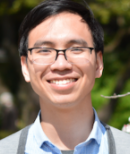

In [633]:
pattern = "B H [(w1 w2 w3) -> (w2)] C"
axes_lengths = dict(B=1, w1=50, w3=51)

res = chunk(tensor, pattern, **axes_lengths)
print(tensor.shape)
print(res.shape)
Image.fromarray(res[0])#[:, :, 0], 'L')

In [580]:
left_dim, right_dim = dim_pattern.split("->")

In [92]:
parse_expression(left_dim)

({'b', 'g', 'r'}, [['g', 'b', 'r']])

In [93]:
parse_expression(right_dim)

({'b', 'g', 'r'}, [['r', 'g', 'b']])

In [ ]:
# TODO parenthesis within brackets
# TODO add logaddexp, std, var, ptp, l1, l2
@functools.lru_cache(256)
def _prepare_transformation_recipe(pattern: str, operation: str, axes_lengths: Tuple[Tuple]) -> TransformRecipe:
    """ Perform initial parsing of pattern and provided supplementary info
    axes_lengths is a tuple of tuples (axis_name, axis_length)
    """
    left, right = pattern.split('->')
    identifiers_left, composite_axes_left = parse_expression(left)
    identifiers_rght, composite_axes_rght = parse_expression(right)

    # checking that both have similar letters
    if operation == 'rearrange':
        difference = set.symmetric_difference(identifiers_left, identifiers_rght)
        if len(difference) > 0:
            raise EinopsError('Identifiers only on one side of expression (should be on both): {}'.format(difference))
    elif operation == 'repeat':
        difference = set.difference(identifiers_left, identifiers_rght)
        if len(difference) > 0:
            raise EinopsError('Unexpected identifiers on the left side of repeat: {}'.format(difference))
        axes_without_size = set.difference(identifiers_rght, {*identifiers_left, *(ax for ax, _ in axes_lengths)})
        if len(axes_without_size) > 0:
            raise EinopsError('Specify sizes for new axes in repeat: {}'.format(axes_without_size))
    elif operation in _reductions:
        difference = set.difference(identifiers_rght, identifiers_left)
        if len(difference) > 0:
            raise EinopsError('Unexpected identifiers on the right side of reduce {}: {}'.format(operation, difference))
    else:
        raise EinopsError('Unknown reduction {}. Expect one of {}.'.format(operation, _reductions))

    # parsing all dimensions to find out lengths
    axis_name2known_length = OrderedDict()
    for composite_axis in composite_axes_left:
        for axis_name in composite_axis:
            axis_name2known_length[axis_name] = None

    # axis_ids_after_first_reshape = range(len(axis_name2known_length))
    # position_lookup_after_reduction = {}

    repeat_axes_names = []
    for axis_name in identifiers_rght:
        if axis_name not in axis_name2known_length:
            axis_name2known_length[axis_name] = None
            repeat_axes_names.append(axis_name)

    axis_name2position = {name: position for position, name in enumerate(axis_name2known_length)}
    reduced_axes = [position for axis, position in axis_name2position.items() if axis not in identifiers_rght]

    for elementary_axis, axis_length in axes_lengths:
        if not _check_elementary_axis_name(elementary_axis):
            raise EinopsError('Invalid name for an axis', elementary_axis)
        if elementary_axis not in axis_name2known_length:
            raise EinopsError('Axis {} is not used in transform'.format(elementary_axis))
        # check that element was not set, this can be deleted
        assert axis_name2known_length[elementary_axis] is None
        axis_name2known_length[elementary_axis] = axis_length

    input_axes_known_unknown = []
    # some of shapes will be inferred later - all information is prepared to know
    for composite_axis in composite_axes_left:
        known = {axis for axis in composite_axis if axis_name2known_length[axis] is not None}
        unknown = {axis for axis in composite_axis if axis_name2known_length[axis] is None}
        if len(unknown) > 1:
            raise EinopsError('Could not infer sizes for {}'.format(unknown))
        assert len(unknown) + len(known) == len(composite_axis)
        input_axes_known_unknown.append(
            ([axis_name2position[axis] for axis in known], [axis_name2position[axis] for axis in unknown]))

    axis_position_after_reduction = {}
    for axis_name in itertools.chain(*composite_axes_left):
        if axis_name in identifiers_rght:
            axis_position_after_reduction[axis_name] = len(axis_position_after_reduction)

    result_axes_grouping = [[axis_name2position[axis] for axis in composite_axis]
                            for composite_axis in composite_axes_rght]
    ordered_axis_right = list(itertools.chain(*composite_axes_rght))
    axes_permutation = tuple(
        axis_position_after_reduction[axis] for axis in ordered_axis_right if axis in identifiers_left)
    added_axes = {i: axis_name2position[axis_name] for i, axis_name in enumerate(ordered_axis_right)
                  if axis_name not in identifiers_left}

    ellipsis_left = math.inf if _ellipsis not in composite_axes_left else composite_axes_left.index(_ellipsis)
    ellipsis_rght = math.inf if _ellipsis not in composite_axes_rght else composite_axes_rght.index(_ellipsis)

#     return TransformRecipe(
#         elementary_axes_lengths=list(axis_name2known_length.values()),
#         input_composite_axes=input_axes_known_unknown,
#         reduced_elementary_axes=tuple(reduced_axes),
#         axes_permutation=axes_permutation,
#         added_axes=added_axes,
#         output_composite_axes=result_axes_grouping,
#         reduction_type=operation,
#         # TODO get rid of ellipses position on right side, put marks directly
#         ellipsis_positions=(ellipsis_left, ellipsis_rght)
#     )


In [ ]:
def reduce(tensor, pattern: str, reduction: str, **axes_lengths: int):
    """
    einops.reduce provides combination of reordering and reduction using reader-friendly notation.
    
    Examples for reduce operation:
    
    >>> x = np.random.randn(100, 32, 64)
    >>> # perform max-reduction on the first axis
    >>> y = reduce(x, 't b c -> b c', 'max')
    >>> # same as previous, but with clearer axes meaning
    >>> y = reduce(x, 'time batch channel -> batch channel', 'max')

    >>> x = np.random.randn(10, 20, 30, 40)
    >>> # 2d max-pooling with kernel size = 2 * 2 for image processing
    >>> y1 = reduce(x, 'b c (h1 h2) (w1 w2) -> b c h1 w1', 'max', h2=2, w2=2)
    >>> # if one wants to go back to the original height and width, depth-to-space trick can be applied
    >>> y2 = rearrange(y1, 'b (c h2 w2) h1 w1 -> b c (h1 h2) (w1 w2)', h2=2, w2=2)
    >>> assert parse_shape(x, 'b _ h w') == parse_shape(y2, 'b _ h w')
    >>> # Adaptive 2d max-pooling to 3 * 4 grid
    >>> reduce(x, 'b c (h1 h2) (w1 w2) -> b c h1 w1', 'max', h1=3, w1=4).shape
    (10, 20, 3, 4)
    >>> # Global average pooling
    >>> reduce(x, 'b c h w -> b c', 'mean').shape
    (10, 20)
    >>> # Subtracting mean over batch for each channel
    >>> y = x - reduce(x, 'b c h w -> () c () ()', 'mean')
    >>> # Subtracting per-image mean for each channel
    >>> y = x - reduce(x, 'b c h w -> b c () ()', 'mean') 
    
    :param tensor: tensor: tensor of any supported library (e.g. numpy.ndarray, tensorflow, pytorch, mxnet.ndarray).
            list of tensors is also accepted, those should be of the same type and shape
    :param pattern: string, reduction pattern
    :param reduction: one of available reductions ('min', 'max', 'sum', 'mean', 'prod'), case-sensitive
    :param axes_lengths: any additional specifications for dimensions
    :return: tensor of the same type as input
    """
    try:
        hashable_axes_lengths = tuple(sorted(axes_lengths.items()))
        recipe = _prepare_transformation_recipe(pattern, reduction, axes_lengths=hashable_axes_lengths)
        return recipe.apply(tensor)
    except EinopsError as e:
        message = ' Error while processing {}-reduction pattern "{}".'.format(reduction, pattern)
        if not isinstance(tensor, list):
            message += '\n Input tensor shape: {}. '.format(get_backend(tensor).shape(tensor))
        else:
            message += '\n Input is list. '
        message += 'Additional info: {}.'.format(axes_lengths)
        raise EinopsError(message + '\n {}'.format(e))

In [ ]:
def rearrange(tensor, pattern, **axes_lengths):
    """
    einops.rearrange is a reader-friendly smart element reordering for multidimensional tensors.
    This operation includes functionality of transpose (axes permutation), reshape (view), squeeze, unsqueeze,
    stack, concatenate and other operations.

    Examples for rearrange operation:

    >>> # suppose we have a set of 32 images in "h w c" format (height-width-channel)
    >>> images = [np.random.randn(30, 40, 3) for _ in range(32)]
    >>> # stack along first (batch) axis, output is a single array
    >>> rearrange(images, 'b h w c -> b h w c').shape
    (32, 30, 40, 3)
    >>> # concatenate images along height (vertical axis), 960 = 32 * 30
    >>> rearrange(images, 'b h w c -> (b h) w c').shape
    (960, 40, 3)
    >>> # concatenated images along horizontal axis, 1280 = 32 * 40
    >>> rearrange(images, 'b h w c -> h (b w) c').shape
    (30, 1280, 3)
    >>> # reordered axes to "b c h w" format for deep learning
    >>> rearrange(images, 'b h w c -> b c h w').shape
    (32, 3, 30, 40)
    >>> # flattened each image into a vector, 3600 = 30 * 40 * 3
    >>> rearrange(images, 'b h w c -> b (c h w)').shape
    (32, 3600)
    >>> # split each image into 4 smaller (top-left, top-right, bottom-left, bottom-right), 128 = 32 * 2 * 2
    >>> rearrange(images, 'b (h1 h) (w1 w) c -> (b h1 w1) h w c', h1=2, w1=2).shape
    (128, 15, 20, 3)
    >>> # space-to-depth operation
    >>> rearrange(images, 'b (h h1) (w w1) c -> b h w (c h1 w1)', h1=2, w1=2).shape
    (32, 15, 20, 12)

    :param tensor: tensor of any supported library (e.g. numpy.ndarray, tensorflow, pytorch, mxnet.ndarray).
            list of tensors is also accepted, those should be of the same type and shape
    :param pattern: string, rearrangement pattern
    :param axes_lengths: any additional specifications for dimensions
    :return: tensor of the same type as input. If possible, a view to the original tensor is returned.

    When composing axes, C-order enumeration used (consecutive elements have different last axis)
    Find more examples in einops tutorial.
    """
    if isinstance(tensor, list):
        if len(tensor) == 0:
            raise TypeError("Rearrange can't be applied to an empty list")
        tensor = get_backend(tensor[0]).stack_on_zeroth_dimension(tensor)
    return reduce(tensor, pattern, reduction='rearrange', **axes_lengths)